In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from test_extract import Data
import re
import seaborn as sns
from typing import Dict, List, Tuple, Any, Callable

FILENAME = "data/CIS_enrollment.csv"
ENCODING = "iso-8859-1"

data = Data(FILENAME)
raw  = pd.read_csv(FILENAME, encoding=ENCODING)

In [2]:
#code taken from Sam
def get_students_in_major(major):
    return dict(filter(lambda s: s[1].major == major, data.students.items()))

def get_prop(course, major=""):
    if major == "":
        students = data.students
    else:
        students = filter(lambda s: s[1].major == major, data.students.items())

    return len(data.courses[course].students) / len(dict(students))

course = "CS1110"
major = "Computer Science"
p = get_prop(course, major)
print(f"{p:.2%} of {major} majors take {course}")

72.79% of Computer Science majors take CS1110


/Users/ericsun/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/ericsun/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/ericsun/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


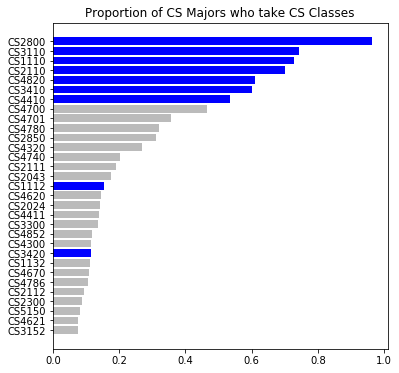

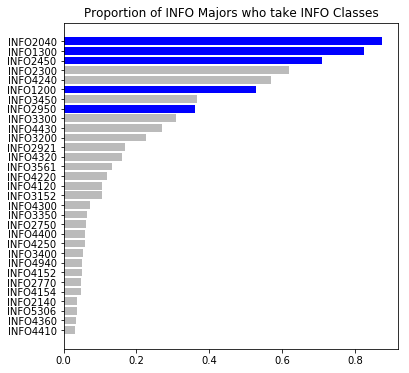

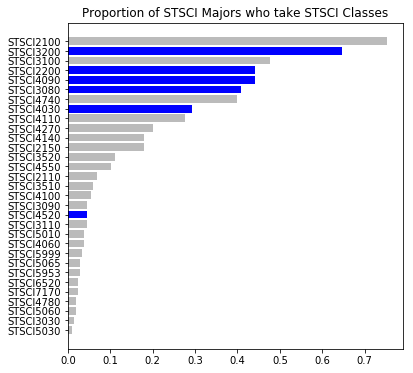

In [3]:
def createCourseGraph(pattern, majorKeyword, major, core):
    courses = list(filter(lambda c: re.match(pattern,c), data.courses.keys()))

    y = [get_prop(course, major) for course in courses]

    core = list(map(lambda n: majorKeyword + str(n), core))

    color = lambda course: 'blue' if course in core else '#bbbbbb'

    df = pd.DataFrame({"Course": courses, "Proportion":y})
    df = df.sort_values("Proportion", ascending=False).reset_index(drop=True)
    df['Core'] = df.Course.map(color)
    sub_df = df.loc[0:30]

    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.barh(sub_df.Course, sub_df.Proportion, color=sub_df.Core)
    ax.invert_yaxis()
    plt.title("Proportion of {} Majors who take {} Classes".format(majorKeyword, majorKeyword))
    fig.show()
    return df

cs_core = [1110, 1112, 2110, 2800, 2802, 3110, 3410, 3420, 4410, 4820]
csDF = createCourseGraph(re.compile(r"^CS\d{4}$"), "CS", "Computer Science", cs_core)

info_core = [1200, 1300, 2040, 2450, 2950]
infoDF = createCourseGraph(re.compile(r"^INFO\d{4}$"), "INFO", "Information Science", info_core)

stsci_core = [2200,3200,3080,4030,4090,4520]
stsciDF = createCourseGraph(re.compile(r"^STSCI\d{4}$"),"STSCI","Statistical Science",stsci_core)

In [4]:
print(["CS" + str(core) for core in cs_core])
print(["INFO" + str(core) for core in info_core])
print(["STSCI" + str(core) for core in stsci_core])

['CS1110', 'CS1112', 'CS2110', 'CS2800', 'CS2802', 'CS3110', 'CS3410', 'CS3420', 'CS4410', 'CS4820']
['INFO1200', 'INFO1300', 'INFO2040', 'INFO2450', 'INFO2950']
['STSCI2200', 'STSCI3200', 'STSCI3080', 'STSCI4030', 'STSCI4090', 'STSCI4520']


In [5]:
#TODO: build a graph of most common nodes to build generic pathway
def makeGraphTemplate(reqCourses:List[str]):
    reqCourseGraph = {}
    for course in reqCourses:
        reqCourseGraph[course] = {}
        for course2 in reqCourses:
            reqCourseGraph[course][course2] = 0
    return reqCourseGraph

def makeGraph(classes:Dict[int,List[str]], reqCourseGraph:Dict[str,Dict[str,int]]):
    prevClasses = []
    for term, termCourses in classes.items():
        for currCourse in termCourses:
            for prevClass in prevClasses:
                reqCourseGraph[prevClass][currCourse] += 1
        prevClasses = termCourses
    return reqCourseGraph

def makeGraphForMajor(requiredCourses:List[str], major:str):
    reqCourseGraph = makeGraphTemplate(requiredCourses)
    students = get_students_in_major(major).values()
    for i,student in enumerate(students):
        classes = student.term_numbers
        termToClass = {i:[] for i in range(1,13)}
        for classTaken, term in classes.items():
            #get all important classes
            if classTaken in requiredCourses:
                termToClass[term].append(classTaken)
        reqCourseGraph = makeGraph(termToClass, reqCourseGraph)
    return reqCourseGraph

In [6]:
def makeNodes(graph):
    nodes = []
    for key in graph.keys():
        nodeToAdd = {"id":key}
        for letter in key:
            if letter.isdigit():
                nodeToAdd["term"] = letter
                break
        nodes.append(nodeToAdd)
    return nodes

def makeLinks(graph, threshold):
    links = []
    for sourceClass, targetClasses in graph.items():
        maxValue = max(targetClasses.values())
        for targetClass, count in targetClasses.items():
            if count / maxValue >= threshold:
                links.append({"source":sourceClass, "target":targetClass})
    return links

def makeNodesLinks(graph):
    nodes = makeNodes(graph)
    links = makeLinks(graph, 1)
    return(nodes,links)
    
def makeNodesLinksPerc(graph, threshold):
    nodes = makeNodes(graph)
    links = makeLinks(graph, threshold)
    return(nodes,links)
    
def makeNodesLinksPercDF(graph, threshold):
    source = []
    target = []
    for sourceClass, targetClasses in graph.items():
        maxValue = max(targetClasses.values())
        for targetClass, count in targetClasses.items():
            if count / maxValue > threshold:
                source.append(sourceClass)
                target.append(targetClass)
    return pd.DataFrame({"from":source,"to":target})

In [7]:
csReqCourses = list(csDF.drop("Core",axis=1)[:10]["Course"])
infoReqCourses = list(infoDF.drop("Core",axis=1)[:10]["Course"])
stsciReqCourses = list(stsciDF.drop("Core",axis=1)[:10]["Course"])
csGraph = makeGraphForMajor(csReqCourses, "Computer Science")
infoGraph = makeGraphForMajor(infoReqCourses, "Information Science")
stsciGraph = makeGraphForMajor(stsciReqCourses, "Statistical Science")
# print(makeNodesLinks(csGraph))
print(makeNodesLinksPerc(csGraph, 0.75))
# print(makeNodesLinks(infoGraph))
print(makeNodesLinksPerc(infoGraph, 0.75))
# print(makeNodesLinks(stsciGraph))
print(makeNodesLinksPerc(stsciGraph, 0.75))

([{'id': 'CS2800', 'term': '2'}, {'id': 'CS3110', 'term': '3'}, {'id': 'CS1110', 'term': '1'}, {'id': 'CS2110', 'term': '2'}, {'id': 'CS4820', 'term': '4'}, {'id': 'CS3410', 'term': '3'}, {'id': 'CS4410', 'term': '4'}, {'id': 'CS4700', 'term': '4'}, {'id': 'CS4701', 'term': '4'}, {'id': 'CS4780', 'term': '4'}], [{'source': 'CS2800', 'target': 'CS3110'}, {'source': 'CS2800', 'target': 'CS3410'}, {'source': 'CS3110', 'target': 'CS4820'}, {'source': 'CS1110', 'target': 'CS2800'}, {'source': 'CS1110', 'target': 'CS2110'}, {'source': 'CS2110', 'target': 'CS2800'}, {'source': 'CS4820', 'target': 'CS4410'}, {'source': 'CS3410', 'target': 'CS4410'}, {'source': 'CS4410', 'target': 'CS4820'}, {'source': 'CS4700', 'target': 'CS4820'}, {'source': 'CS4701', 'target': 'CS4820'}, {'source': 'CS4780', 'target': 'CS4820'}])
([{'id': 'INFO2040', 'term': '2'}, {'id': 'INFO1300', 'term': '1'}, {'id': 'INFO2450', 'term': '2'}, {'id': 'INFO2300', 'term': '2'}, {'id': 'INFO4240', 'term': '4'}, {'id': 'INFO12

# Using Danny's Graph

In [8]:
#using Danny's thing
import graph

In [9]:
def makeGraph2(reqCourses, major, g):
    edges = []
    maxValue = 0
    for cname1 in reqCourses:
        for cname2 in reqCourses:
            if cname2 == cname1:
                continue
            course = data.courses[cname1]
            nextCount, sameCount = 0, 0
            for s in course.students:
                if s.major != major:
                    continue
                if cname2 in s.term_numbers and s.term_numbers[cname2] == s.term_numbers[cname1] + 1:
                    nextCount += 1
                elif cname2 in s.term_numbers and s.term_numbers[cname2] == s.term_numbers[cname1]:
                    sameCount += 1
            if nextCount > sameCount:
                edges.append([cname1, cname2, nextCount])
                if nextCount > maxValue: maxValue = nextCount
            else:
                edges.append([cname1, cname2, sameCount])
                if sameCount > maxValue: maxValue = sameCount
    
    uniqueEdges = {}
    for edge in edges:
        cname1 = edge[0]
        cname2 = edge[1]
        count = edge[2] / maxValue
        if count in uniqueEdges
        g.addEdge(cname1, cname2, count)
    
    return g

In [17]:
def displayGraph(graph, threshold):
    print("DISPLAYING . . .")
    for e in graph.filterEdges(lambda e: e.weight > threshold):
        print(str(e))

In [18]:
csGraph = graph.Graph()
infoGraph = graph.Graph()
statsGraph = graph.Graph()
csGraph = makeGraph2(csReqCourses, "Computer Science", csGraph)
infoGraph = makeGraph2(infoReqCourses, "Information Science", infoGraph)
statsGraph = makeGraph2(stsciReqCourses, "Statistical Science", statsGraph)

displayGraph(csGraph, 0.5)
displayGraph(infoGraph, 0.5)

DISPLAYING . . .
(CS2800,CS3110,1.0)
(CS2800,CS2110,0.675365344467641)
(CS2800,CS3410,0.8183716075156576)
(CS3110,CS4820,0.8569937369519833)
(CS3110,CS3410,0.6419624217118998)
(CS1110,CS2800,0.6325678496868476)
(CS1110,CS2110,0.7818371607515657)
(CS2110,CS2800,0.6889352818371608)
(CS2110,CS3110,0.5125260960334029)
(CS4820,CS4410,0.627348643006263)
(CS3410,CS3110,0.5668058455114823)
(CS3410,CS4410,0.8183716075156576)
(CS4700,CS4701,0.9697286012526096)
(CS4701,CS4700,0.9697286012526096)
DISPLAYING . . .
(INFO2040,INFO1300,1.0)
(INFO2040,INFO2450,0.7885714285714286)
(INFO2040,INFO2300,0.6571428571428571)
(INFO1300,INFO2040,1.0)
(INFO1300,INFO2450,0.7571428571428571)
(INFO1300,INFO2300,0.9828571428571429)
(INFO2450,INFO2040,0.7885714285714286)
(INFO2450,INFO1300,0.7571428571428571)


In [35]:
g.export_graph("STSCI_req_test",0.5)

done! exported as INFO_req_test.dot
